In [34]:
import numpy as np
import xarray as xr
import numpy as np
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Dropout, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import matplotlib.pyplot as plt

In [18]:
dtrain0 = xr.open_dataset('data/tb_train.nc')
dval0 = xr.open_dataset('data/tb_val.nc')
dtest0 = xr.open_dataset('data/tb_test.nc')
# normalize data 
def datnorm(d): 
    return (d - d.mean()) / d.std() 
# normalize data
dtrain, dval, dtest = datnorm(dtrain0), datnorm(dval0), datnorm(dtest0)
int_data = dtrain['lo'].values
X_train = np.expand_dims(int_data,3)
y_train = dtrain['hi'].values
X_val = np.expand_dims(dval['lo'].values,3)
y_val = dval['hi'].values
X_test = np.expand_dims(dtest['lo'].values,3)
y_test = dtest['hi'].values
print('Shape of X_train: ', X_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of X_validation: ', X_val.shape)
print('Shape of y_validation: ', y_val.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)

Shape of X_train:  (255, 24, 32, 1)
Shape of y_train:  (255, 24, 32)
Shape of X_validation:  (66, 24, 32, 1)
Shape of y_validation:  (66, 24, 32)
Shape of X_test:  (44, 24, 32, 1)
Shape of y_test:  (44, 24, 32)


In [19]:
y_train

array([[[ 0.9298581 ,  1.1772969 ,  1.2084239 , ...,  2.066577  ,
          2.0356708 ,  2.245144  ],
        [ 0.6534715 ,  0.5311699 ,  0.34910032, ...,  2.0623262 ,
          2.0005515 ,  2.076663  ],
        [ 0.2950896 ,  0.4496427 ,  0.37138957, ...,  2.5785973 ,
          2.484404  ,  2.3983302 ],
        ...,
        [ 2.190447  ,  2.1970599 ,  2.2141325 , ...,  2.3436065 ,
          1.7517405 ,  1.6764252 ],
        [ 2.2367392 ,  2.2066212 ,  2.254966  , ...,  1.7507155 ,
          1.7875997 ,  1.6924918 ],
        [ 2.253968  ,  2.2703574 ,  2.2425854 , ...,  2.0070646 ,
          2.0483904 ,  1.791697  ]],

       [[ 1.1112497 ,  1.3395578 ,  1.4210446 , ...,  1.6498584 ,
          1.4626395 ,  1.4217279 ],
        [ 0.78134745,  0.64527684,  0.42875242, ...,  1.3590436 ,
          1.2753319 ,  1.2707584 ],
        [ 0.3325549 ,  0.42268038,  0.36211875, ...,  1.7241405 ,
          1.484875  ,  1.3824843 ],
        ...,
        [ 2.3811014 ,  2.485682  ,  2.6826398 , ...,  

In [31]:
# Define the input shape, e.g., 24x32 grayscale images
input_shape = (24, 32, 1)  # (height, width, channels)

# Define the input layer
inputs = Input(shape=input_shape)

# Encoder (Downsampling Path)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

# Bottleneck
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Decoder (Upsampling Path)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

# Output layer: single channel for continuous values
outputs = Conv2D(1, (1, 1), activation='linear', padding='same')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='mse',  # Mean Squared Error for continuous output
              metrics=['mae'])  # Mean Absolute Error as an additional metric

# Summary of the model architecture
model.summary()

# Train the model
history = model.fit(X_train, y_train, batch_size=8, epochs=50, validation_data=(X_val, y_val))


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 24, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 24, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 24, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 12, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 12, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 12, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 12, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 6, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 6, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 6, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_20 (UpSampling2D) │ (None, 12, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 12, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 12, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_21 (UpSampling2D) │ (None, 24, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 24, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 24, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 24, 32, 1)      │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,241 (727.50 KB)

 Trainable params: 185,601 (725.00 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 1.8487 - mae: 0.9831 - val_loss: 0.9377 - val_mae: 0.6661
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.8244 - mae: 0.6518 - val_loss: 0.9077 - val_mae: 0.6626
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.5896 - mae: 0.5429 - val_loss: 0.8558 - val_mae: 0.6479
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.4435 - mae: 0.4625 - val_loss: 0.8001 - val_mae: 0.6308
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.3784 - mae: 0.4102 - val_loss: 0.7010 - val_mae: 0.5614
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.3663 - mae: 0.4141 - val_loss: 0.6180 - val_mae: 0.5232
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.3254 - mae: 0.3934 - val_loss: 0.5437 - val_mae: 0.5103
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.2633 - mae: 0.3435 - val_loss: 0.4485 - val_mae: 0.4307
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.281

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 24, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 24, 32, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 24, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 12, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 12, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 12, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 12, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 6, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 6, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 6, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 6, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 6, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_24 (UpSampling2D) │ (None, 12, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 12, 16, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 12, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_25 (UpSampling2D) │ (None, 24, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 24, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 24, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 24, 32, 1)      │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 741,121 (2.83 MB)

 Trainable params: 739,841 (2.82 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 2.0740 - mae: 1.0663 - val_loss: 0.9624 - val_mae: 0.6795 - learning_rate: 5.0000e-05
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.9920 - mae: 0.7212 - val_loss: 0.9920 - val_mae: 0.7130 - learning_rate: 5.0000e-05
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 0.7074 - mae: 0.6049 - val_loss: 0.9984 - val_mae: 0.6973 - learning_rate: 5.0000e-05
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.5440 - mae: 0.5231 - val_loss: 0.9818 - val_mae: 0.6760 - learning_rate: 5.0000e-05
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.4423 - mae: 0.4690 - val_loss: 0.9289 - val_mae: 0.6362 - learning_rate: 5.0000e-05
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.4091 - mae: 0.4597 - val_loss: 0.8694 - val_mae: 0.5945 - learning_rate: 5.0000e-05
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.3187 - mae: 0.3913 - val_loss: 0.7742 - val_mae: 0.5723

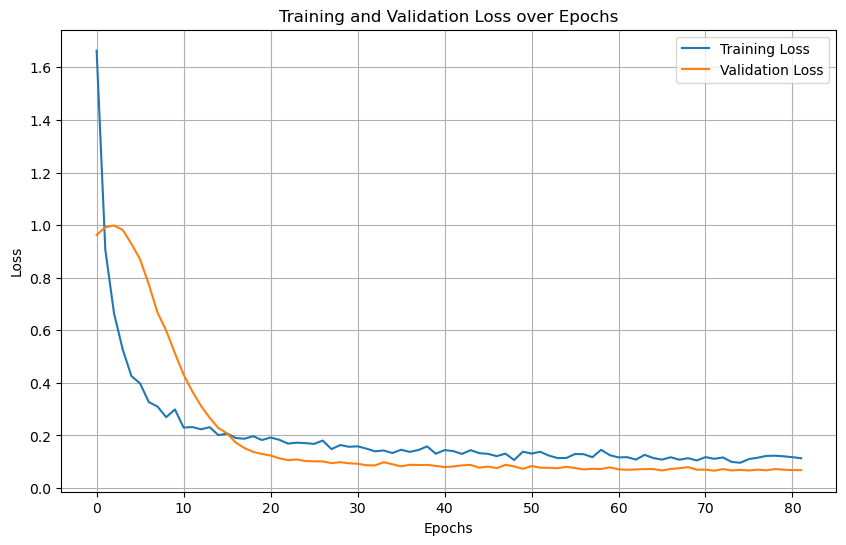

In [35]:
# Define the input shape
input_shape = (24, 32, 1)  # (height, width, channels)

# Define the input layer
inputs = Input(shape=input_shape)

# Encoder (Downsampling Path)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)  # Increased filters
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # Increased filters
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

# Bottleneck
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)  # Increased filters
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Decoder (Upsampling Path)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

# Output layer for continuous values
outputs = Conv2D(1, (1, 1), activation='linear', padding='same')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with a smaller learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              loss='mse',
              metrics=['mae'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Summary of the model architecture
model.summary()

# Train the model with callbacks
history = model.fit(X_train, y_train, batch_size=8, epochs=100, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

# Plotting the loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
<xarray.Dataset> Size: 272kB
Dimensions:    (dat: 44, latitude: 24, longitude: 32, date: 44)
Coordinates:
  * latitude   (latitude) float32 96B 42.3 41.6 40.9 40.2 ... 27.6 26.9 26.2
  * longitude  (longitude) float32 128B 75.5 76.2 76.9 77.6 ... 95.8 96.5 97.2
  * date       (date) <U8 1kB '20230111' '20230117' ... '20231221' '20231226'
Dimensions without coordinates: dat
Data variables:
    pred       (dat, latitude, longitude) float32 135kB 269.1 266.0 ... 272.7
    real       (date, latitude, longitude) float32 135kB 251.8 257.0 ... 272.3
<xarray.Dataset> Size: 408kB
Dimensions:    (dat: 66, latitude: 24, longitude: 32, date: 66)
Coordinates:
  * latitude   (latitude) float32 96B 42.3 41.6 40.9 40.2 ... 27.6 26.9 26.2
  * longitude  (longitude) float32 128B 75.5 76.2 76.9 77.6 ... 95.8 96.5 97.2
  * date       (date) <U8 2kB '20230924' '20230607' ... '20230305' '20230806'
Dimensions without coordinates: da

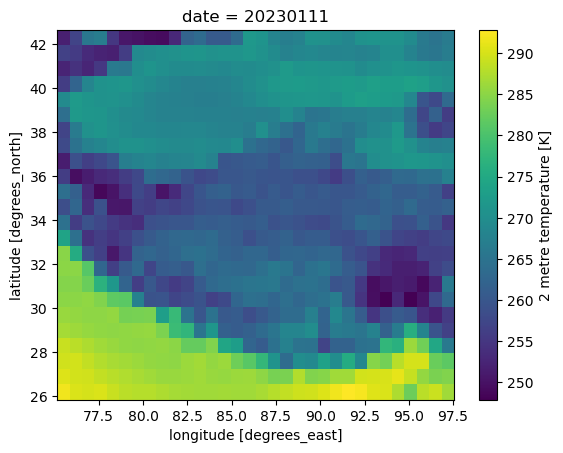

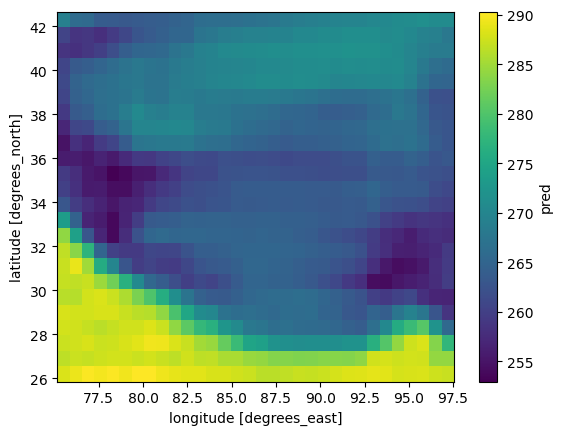

In [36]:
# load model and run
#xmodel = tf.keras.models.load_model('tb_small_1.keras') 
xmodel = model
#print(xmodel.summary())

y_pred_val = xmodel.predict(X_val, verbose=1)
y_pred_test = xmodel.predict(X_test, verbose=1) 

# return values to Kelvin 
x1, x2 = dtest0.mean()['hi'], dtest0.std()['hi']
y_pred_test_r = y_pred_test*x2.values + x1.values

x1, x2 = dval0.mean()['hi'], dval0.std()['hi']
y_pred_val_r = y_pred_val*x2.values + x1.values


do = xr.Dataset( )
do['pred'] = ( ('dat', 'latitude', 'longitude'), y_pred_test_r.squeeze())  
do.coords['latitude'] = dtest0.latitude
do.coords['longitude'] = dtest0.longitude
do['real'] = dtest0['hi']

dv = xr.Dataset( )
dv['pred'] = ( ('dat', 'latitude', 'longitude'), y_pred_val_r.squeeze())  
dv.coords['latitude'] = dval0.latitude
dv.coords['longitude'] = dval0.longitude
dv['real'] = dval0['hi']

odir = 'output/'
if not os.path.exists(odir): os.makedirs(odir)
do.to_netcdf(odir+'prediction.nc')
dv.to_netcdf(odir+'validation.nc')
do.close()
dv.close()

#do.pred[0].plot()
#plt.show()
#dtest0['hi'][0].plot()
#plt.show()
#bias = do.pred - dtest0.hi.values
#bias[0].plot()
#print(bias.mean())   

print(do)
print(dv)

do['real'][0].plot()
plt.show()
do['pred'][0].plot()